# Cell type annotation prediction - Jansky & Westerhout


In this notebook, an [scGPT](https://www.nature.com/articles/s41592-024-02201-0) model is used to predict a cell type annotation with a given gene expression profile.

This follows the tutorial from scGPT [here](https://github.com/bowang-lab/scGPT/blob/main/tutorials/Tutorial_Annotation.ipynb), but instead of fine-tuning the entire model, a smaller neural network is trained, using the embeddings of the gene expressions as inputs, to make a prediction.

The same approach is made with the [Geneformer](https://www.nature.com/articles/s41586-023-06139-9.epdf?sharing_token=u_5LUGVkd3A8zR-f73lU59RgN0jAjWel9jnR3ZoTv0N2UB4yyXENUK50s6uqjXH69sDxh4Z3J4plYCKlVME-W2WSuRiS96vx6t5ex2-krVDS46JkoVvAvJyWtYXIyj74pDWn_DutZq1oAlDaxfvBpUfSKDdBPJ8SKlTId8uT47M%3D) model and the results are compared against each other.

This approach greatly reduces time and complexity.

In [1]:
#!pip3 install helical
#!conda install -c conda-forge louvain
#!pip3 install datasets --upgrade

In [1]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import anndata as ad
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from scipy.sparse import lil_matrix
import torch.optim as optim
from helical.models.scgpt import scGPT, scGPTConfig
from helical.models.geneformer import Geneformer, GeneformerConfig
from copy import deepcopy
from torch.nn.functional import one_hot
import scanpy as sc

  from .autonotebook import tqdm as notebook_tqdm

INFO:datasets:PyTorch version 2.6.0 available.


Fine-tuning data: Jansky

In [2]:
# Load fine-tuning data
adata = sc.read_h5ad("jansky_adrenal_medulla.h5ad")


In [5]:
# Seurat to AnnData conversion can be tricky. Ensure that the raw counts are properly assigned. 
print(adata.X)
print(adata.raw.X)

  (0, 17)	1.0
  (0, 40)	2.0
  (0, 46)	1.0
  (0, 47)	1.0
  (0, 48)	1.0
  (0, 135)	1.0
  (0, 143)	1.0
  (0, 145)	1.0
  (0, 161)	5.0
  (0, 184)	3.0
  (0, 186)	1.0
  (0, 189)	1.0
  (0, 215)	1.0
  (0, 216)	1.0
  (0, 229)	2.0
  (0, 251)	2.0
  (0, 253)	1.0
  (0, 282)	1.0
  (0, 289)	2.0
  (0, 290)	3.0
  (0, 300)	1.0
  (0, 301)	1.0
  (0, 333)	1.0
  (0, 335)	4.0
  (0, 343)	1.0
  :	:
  (10738, 25656)	1.0
  (10738, 25678)	1.0
  (10738, 25712)	2.0
  (10738, 25722)	1.0
  (10738, 25733)	3.0
  (10738, 25757)	1.0
  (10738, 25758)	1.0
  (10738, 25776)	1.0
  (10738, 25783)	4.0
  (10738, 25785)	1.0
  (10738, 25812)	1.0
  (10738, 25853)	1.0
  (10738, 25868)	2.0
  (10738, 25928)	3.0
  (10738, 25974)	2.0
  (10738, 26000)	1.0
  (10738, 26013)	1.0
  (10738, 26017)	1.0
  (10738, 26018)	3.0
  (10738, 26020)	1.0
  (10738, 26021)	1.0
  (10738, 26024)	1.0
  (10738, 26032)	1.0
  (10738, 26037)	1.0
  (10738, 27323)	1.0
  (0, 17)	1.0
  (0, 40)	2.0
  (0, 46)	1.0
  (0, 47)	1.0
  (0, 48)	1.0
  (0, 135)	1.0
  (0, 143)	1.0

In [4]:
# Copy raw counts to adata.X if necessary
adata.X = adata.raw.X.copy()
adata.var["gene_name"] = adata.var_names # "Data must have the provided key 'gene_name' in its 'var' section to be processed by the Helical RNA model."

Randomly choose approx. 20% of patients to leave out for test set (final evaluation).

In [6]:
import random

  # unique patient ids
unseen_patients = random.sample(list(set(adata.obs['orig.ident'])), 3)
print(unseen_patients)

adata_evaluation = adata[adata.obs["orig.ident"].isin(unseen_patients)]
adata_finetuning  = adata[~adata.obs["orig.ident"].isin(unseen_patients)]


['14607', '14627', '13567']


We are interested in the names of the cells we want to predict. They are saved in `adata.obs["active_ident_celltypes"]`.

Additionally, we need to know how many distinct cell types/classes we have.

In [7]:
adata_finetuning.obs


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,CC.Difference,RNA_snn_res.1,...,DF.classifications_0.25_0.005_501,pANN_0.25_0.23_0,DF.classifications_0.25_0.23_0,pANN_0.25_0.24_1356,DF.classifications_0.25_0.24_1356,pANN_0.25_0.24_1085,DF.classifications_0.25_0.24_1085,RNA_snn_res.5,gland_clusters,active_ident_celltypes
AAACCCAGTTTGGCTA_2,12614,3601.0,2032,0.027770,-0.023028,-0.108473,G1,12614,0.085445,15,...,NA,NaN,NA,NaN,NA,NaN,NA,21,1,connecting Chromaffin cells
AAACGCTCACCATTCC_2,12614,3329.0,2114,0.000000,-0.095662,-0.077115,G1,12614,-0.018546,21,...,NA,NaN,NA,NaN,NA,NaN,NA,42,3,SCPs
AAAGAACAGGTCCCTG_2,12614,2043.0,1483,0.000000,0.035215,-0.043380,S,12614,0.078595,15,...,NA,NaN,NA,NaN,NA,NaN,NA,21,1,connecting Chromaffin cells
AAAGGATCATCTAACG_2,12614,1926.0,1391,0.000000,-0.046997,0.008074,G2M,12614,-0.055071,19,...,NA,NaN,NA,NaN,NA,NaN,NA,23,2,connecting Chromaffin cells
AAAGGTAGTCTGATAC_2,12614,3436.0,1922,0.029104,-0.043467,-0.028777,G1,12614,-0.014690,15,...,NA,NaN,NA,NaN,NA,NaN,NA,72,1,Bridge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTACGTTTCCACGTAA_17,14773,1843.0,1355,1.899078,-0.098486,-0.034321,G1,14773,-0.064164,12,...,NA,0.193362,Singlet,0.194976,Singlet,0.194976,Singlet,23,0,connecting Chromaffin cells
TTCCGGTTCGGTAGGA_17,14773,1853.0,1227,0.269833,0.019770,-0.074358,S,14773,0.094128,19,...,NA,0.323713,Singlet,0.320811,Singlet,0.320811,Singlet,23,2,Neuroblasts
TTGGTTTAGTTGAATG_17,14773,2531.0,1527,0.158040,0.041482,-0.074001,S,14773,0.115483,30,...,NA,0.257816,Singlet,0.258585,Singlet,0.258585,Singlet,47,4,late Chromaffin cells
TTGTGGATCTCGGCTT_17,14773,1643.0,1054,0.304321,-0.027369,-0.064153,G1,14773,0.036784,30,...,NA,0.194565,Singlet,0.195206,Singlet,0.195206,Singlet,47,4,late Chromaffin cells


In [8]:
adata_finetuning.var

,vst.mean,vst.variance,vst.variance.expected,vst.variance.standardized,vst.variable,gene_name
RP11-34P13.7,0.002512,0.002506,0.002643,0.948367,0,RP11-34P13.7
AL627309.1,0.004932,0.004908,0.005316,0.923144,0,AL627309.1
AP006222.2,0.030055,0.030457,0.035064,0.868621,0,AP006222.2
RP4-669L17.10,0.086815,0.089336,0.107894,0.827992,0,RP4-669L17.10
RP5-857K21.15,0.000000,0.000000,0.000000,0.000000,0,RP5-857K21.15
...,...,...,...,...,...,...
CTD-2382H12.2,0.000000,0.000000,0.000000,0.000000,0,CTD-2382H12.2
RP4-737E23.2,0.000000,0.000000,0.000000,0.000000,0,RP4-737E23.2
BPIFB6,0.000000,0.000000,0.000000,0.000000,0,BPIFB6
RLN3,0.000000,0.000000,0.000000,0.000000,0,RLN3


In [9]:
# get labels: the celltype
num_types = adata_finetuning.obs["active_ident_celltypes"].unique().shape[0]
id2type = dict(enumerate(adata_finetuning.obs["active_ident_celltypes"].astype("category").cat.categories))

celltypes_labels = np.array(adata_finetuning.obs["active_ident_celltypes"].tolist())

This is all summarized in this dictionary:

In [10]:
id2type

{0: 'Bridge',
 1: 'Chromaffin cells',
 2: 'Neuroblasts',
 3: 'SCPs',
 4: 'connecting Chromaffin cells',
 5: 'cycling Neuroblasts',
 6: 'cycling SCPs',
 7: 'late Chromaffin cells',
 8: 'late Neuroblasts',
 9: 'late SCPs'}

Use the Helical package to get the embeddings of the gene expression profile.

The only thing we need to specify is the column containing the names of the genes. (`gene_name` in this case)

The resulting embeddings are the input features `x` for our smaller NN model.

# scGPT

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Configure and initialize the scGPT model
scgpt_config = scGPTConfig(batch_size=50, device=device)
scgpt = scGPT(configurer = scgpt_config)

# Process the data for the scGPT model
Normalize_SubsetHighlyVariable = False # This logic is also connected to processing the left out data (adata_unseen).

if Normalize_SubsetHighlyVariable:
    data_processed = scgpt.process_data(adata_finetuning, gene_names = "gene_name", fine_tuning=True)
else:
    data_processed = scgpt.process_data(adata_finetuning, gene_names = "gene_name")

# Get embeddings
x_scgpt = scgpt.get_embeddings(data_processed)
x_scgpt.shape

  warnings.warn(

INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:'scGPT' model is in 'eval' mode, on device 'cuda' with embedding mode 'cell'.
INFO:helical.models.scgpt.model:Processing data for scGPT.
  adata.obs["total_counts"] = adata.X.sum(axis=1)

INFO:helical.models.scgpt.model:Filtering out 4506 genes to a total of 23916 genes with an ID in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Successfully processed the data for scGPT.
INFO:helical.models.scgpt.model:Started getting embeddings:
  torch.cuda.amp.autocast(enabled=True),

Embedding cells: 100%|██████████| 161/161 [01:09<00:00,  2.32it/s]
INFO:helical.models.scgpt.model:Finished getting embeddings.


(8024, 512)

With the input features, we also need the corresponding labels `y`.

They correspond to the cell type labels.

As we have a categorical prediction, we transform the cell type labels to integer labels to work with CrossEntropyLoss later.

In [12]:
y = celltypes_labels

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = one_hot(torch.tensor(y_encoded),num_types).float()

In [13]:
freq = pd.Series(y).value_counts()
freq

late Neuroblasts               1566
Chromaffin cells               1314
Neuroblasts                     998
late Chromaffin cells           905
connecting Chromaffin cells     847
cycling Neuroblasts             665
late SCPs                       571
SCPs                            537
Bridge                          467
cycling SCPs                    154
Name: count, dtype: int64

## Define and train the model

In [14]:
input_shape = 512

# Define the model architecture
head_model = nn.Sequential(
    nn.Linear(input_shape, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(32, num_types)
    )

print(head_model)

Sequential(
  (0): Linear(in_features=512, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=128, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.4, inplace=False)
  (6): Linear(in_features=32, out_features=10, bias=True)
)


In [15]:
def train_model(model: nn.Sequential,
                X_train: torch.Tensor,
                y_train: torch.Tensor,
                X_val: torch.Tensor,
                y_val: torch.Tensor,
                optimizer = optim.Adam,
                loss_fn = nn.CrossEntropyLoss(),
                num_epochs = 100,
                batch = 64):

    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

    # Validation dataset
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    # Ensure model is in training mode
    model.train()

    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_X)

            # Compute loss
            loss = loss_fn(outputs, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase (optional)
        model.eval()
        with torch.no_grad():
            val_losses = []
            for val_X, val_y in val_loader:
                val_outputs = model(val_X)
                val_loss = loss_fn(val_outputs, val_y)
                val_losses.append(val_loss.item())

            print(f"Epoch {epoch+1}, Validation Loss: {sum(val_losses)/len(val_losses)}")

        # Set back to training mode for next epoch
        model.train()

    model.eval()
    return model

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x_scgpt, y_encoded, test_size=0.1, random_state=42)

head_model_scgpt = deepcopy(head_model)
head_model_scgpt = train_model(head_model_scgpt,
                               torch.from_numpy(X_train),
                               y_train,
                               torch.from_numpy(X_test),
                               y_test,
                               optim.Adam(head_model_scgpt.parameters(), lr=0.001),
                               nn.CrossEntropyLoss())

Epoch 1, Validation Loss: 1.9521345175229585
Epoch 2, Validation Loss: 1.4343505180799043
Epoch 3, Validation Loss: 1.251038331251878
Epoch 4, Validation Loss: 1.111929109463325
Epoch 5, Validation Loss: 1.0040929455023546
Epoch 6, Validation Loss: 0.9298101159242483
Epoch 7, Validation Loss: 0.8798042856729947
Epoch 8, Validation Loss: 0.8282193587376521
Epoch 9, Validation Loss: 0.7753233909606934
Epoch 10, Validation Loss: 0.732994217139024
Epoch 11, Validation Loss: 0.7102854802058294
Epoch 12, Validation Loss: 0.6973039691264813
Epoch 13, Validation Loss: 0.654888772047483
Epoch 14, Validation Loss: 0.6482445666423211
Epoch 15, Validation Loss: 0.6293982404928941
Epoch 16, Validation Loss: 0.6067406030801626
Epoch 17, Validation Loss: 0.5997068744439346
Epoch 18, Validation Loss: 0.5938648100082691
Epoch 19, Validation Loss: 0.5734034524514124
Epoch 20, Validation Loss: 0.5708933082910684
Epoch 21, Validation Loss: 0.5610853250210102
Epoch 22, Validation Loss: 0.558367140018023
Ep

In [17]:
# Predictions on the test set and ground truth
predictions_nn = head_model_scgpt(torch.Tensor(X_test))
y_pred = np.array(torch.argmax(predictions_nn, dim=1))
y_true = np.array(y_test.argmax(axis=1))

## Present the results
- on the test set and,
- a separate, unseen evaluation set

In [18]:
def get_evaluations(name_data_set, y_true, y_pred) -> dict:
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  print(f"{name_data_set} accuracy: {(accuracy*100):.1f}%")
  print(f"{name_data_set} precision: {(precision*100):.1f}%")
  print(f"{name_data_set} f1: {(f1*100):.1f}%")
  print(f"{name_data_set} recall: {(recall*100):.1f}%")
  return {
      "accuracy": accuracy,
      "precision": precision,
      "f1": f1,
      "recall": recall,
  }

In [19]:
get_evaluations("Test set", y_true, y_pred)

Test set accuracy: 86.2%
Test set precision: 85.6%
Test set f1: 85.3%
Test set recall: 85.1%


{'accuracy': 0.8617683686176837,
 'precision': 0.8559931095450477,
 'f1': 0.852532084186951,
 'recall': 0.8511037136265941}

{0: 'Bridge', 1: 'Chromaffin cells', 2: 'Neuroblasts', 3: 'SCPs', 4: 'connecting Chromaffin cells', 5: 'cycling Neuroblasts', 6: 'cycling SCPs', 7: 'late Chromaffin cells', 8: 'late Neuroblasts', 9: 'late SCPs'}


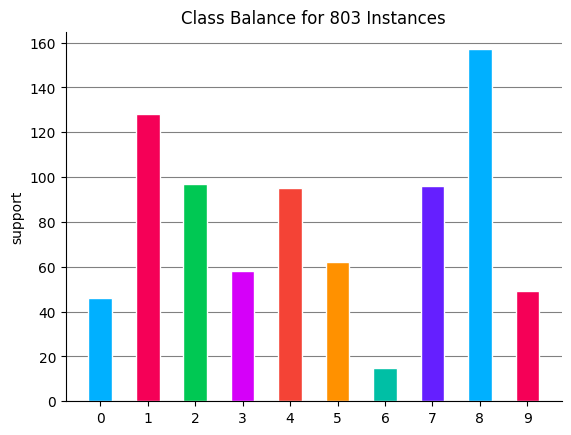

In [20]:
# Visualize class distribution
from sklearn_evaluation import plot
plot.target_analysis(y_true)
print(id2type)

Load the unseen evaluation set. Two options:

1. Evaluation: Load the left out evaluation set from the finetuning dataset. (with true labels - Jansky)
2. Target: Load the dataset that the predictions will be made on. (no true labels - Westerhout)

In [21]:
final_task = "evaluation" # "evaluation" or "target"
if final_task == "target":
    adata_unseen = sc.read_h5ad("chayenne_scRNAseq.h5ad")
    adata_unseen.X = adata_unseen.raw.X.copy()
    adata_unseen.var["gene_name"] = adata_unseen.var_names # "Data must have the provided key 'gene_name' in its 'var' section to be processed by the Helical RNA model."
elif final_task == "evaluation": 
    adata_unseen = adata_evaluation # AnnData preprocessing was done before the finetuning - evaluation split.
    

In [22]:
# Process the unseen data
if Normalize_SubsetHighlyVariable:
    data_processed = scgpt.process_data(adata_unseen, gene_names = "gene_name", fine_tuning=True)
else:
    data_processed = scgpt.process_data(adata_unseen, gene_names = "gene_name")

# Get embeddings and predictions
x_unseen = scgpt.get_embeddings(data_processed)
predictions_nn_unseen = head_model_scgpt(torch.Tensor(x_unseen))

INFO:helical.models.scgpt.model:Processing data for scGPT.
  adata.obs["total_counts"] = adata.X.sum(axis=1)

INFO:helical.models.scgpt.model:Filtering out 4506 genes to a total of 23916 genes with an ID in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Successfully processed the data for scGPT.
INFO:helical.models.scgpt.model:Started getting embeddings:
  torch.cuda.amp.autocast(enabled=True),

Embedding cells: 100%|██████████| 55/55 [00:23<00:00,  2.33it/s]
INFO:helical.models.scgpt.model:Finished getting embeddings.


Unseen evaluation set accuracy: 80.1%
Unseen evaluation set precision: 73.9%
Unseen evaluation set f1: 75.6%
Unseen evaluation set recall: 81.1%
{0: 'Bridge', 1: 'Chromaffin cells', 2: 'Neuroblasts', 3: 'SCPs', 4: 'connecting Chromaffin cells', 5: 'cycling Neuroblasts', 6: 'cycling SCPs', 7: 'late Chromaffin cells', 8: 'late Neuroblasts', 9: 'late SCPs'}


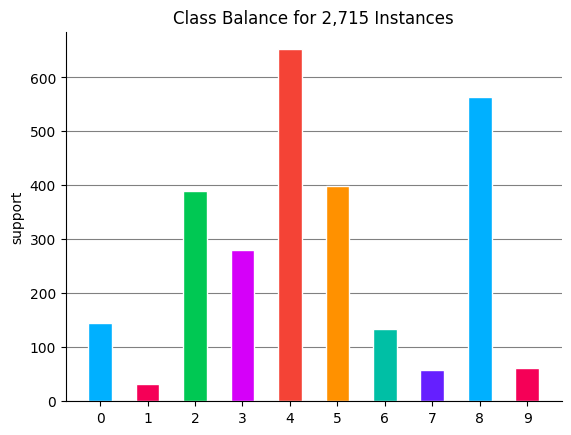

In [23]:
if final_task == "evaluation":
    y_pred_unseen = np.array(torch.argmax(predictions_nn_unseen, dim=1))
    y_true_unseen = np.array(adata_unseen.obs["active_ident_celltypes"].astype("category").cat.codes)
    get_evaluations("Unseen evaluation set", y_true_unseen, y_pred_unseen)
    plot.target_analysis(y_true_unseen)
    print(id2type)
elif final_task == "target":
    save_annData_with_predictions = True

    y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen, dim=1))]
    if save_annData_with_predictions:
        adata_unseen.obs["cell_type_predictions"] = y_pred_unseen
        adata_unseen.obs.to_csv("chayenne_scRNAseq_celltype_preds.csv")

    print(adata_unseen.obs)


We should double check that the cell types are mapped to the correct id numbers for both the training data and this new data set.

In [24]:
if final_task == "evaluation":
    num_types = adata_unseen.obs["active_ident_celltypes"].unique().shape[0]
    id2type_unseen = dict(enumerate(adata_unseen.obs["active_ident_celltypes"].astype("category").cat.categories))
    print(id2type_unseen == id2type)

True


In [26]:
if final_task == "evaluation":
    y_true_unseen = np.array(adata_unseen.obs["active_ident_celltypes"].tolist())
    y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen, dim=1))]

    scgpt_results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

Evaluation set accuracy: 80.1%
Evaluation set precision: 73.9%
Evaluation set f1: 75.6%
Evaluation set recall: 81.1%


Plot a confusion matrix to visualise the classification performance for each the cell type. This is done for the evalation set.

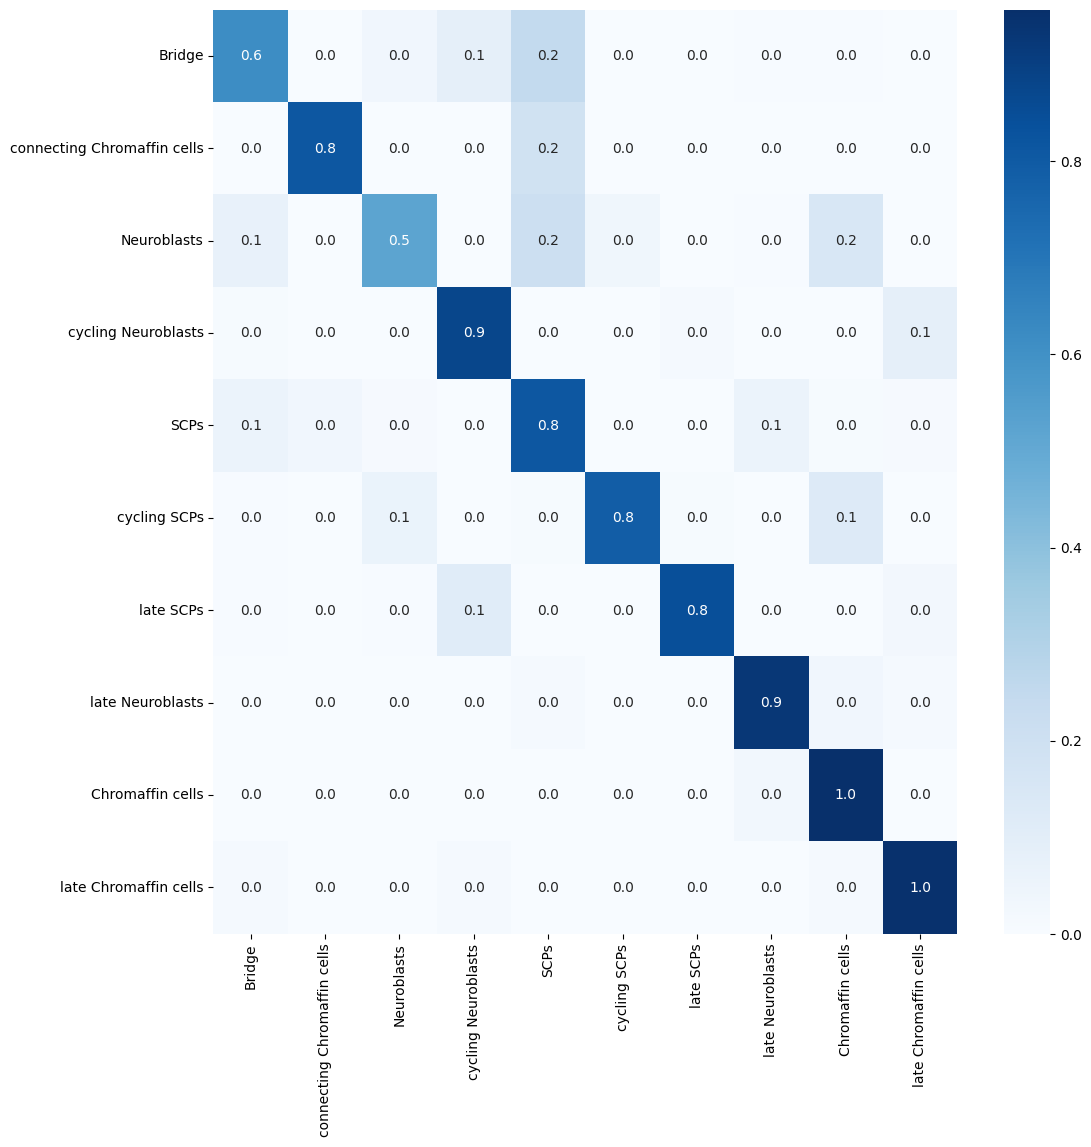

In [28]:
if final_task == "evaluation":
    from sklearn.metrics import confusion_matrix
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    set_predicted_cell_types = list(adata_unseen.obs["active_ident_celltypes"].unique())
    for i in set(y_pred_unseen):
        if i not in set_predicted_cell_types:
            set_predicted_cell_types.remove(i)

    cm = confusion_matrix(y_true_unseen, y_pred_unseen)
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm = pd.DataFrame(cm, index=set_predicted_cell_types[:cm.shape[0]], columns=set_predicted_cell_types[:cm.shape[1]])
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")

# Geneformer

Let's do the same with the Geneformer.

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if 'rows' in adata.obs:
    adata_finetuning.obs['rows'] = adata_finetuning.obs['rows'].astype(str)
geneformer_config = GeneformerConfig(batch_size=50, device=device)
geneformer = Geneformer(configurer = geneformer_config)

data_geneformer = geneformer.process_data(adata_finetuning, gene_names = "gene_name")
x_geneformer = geneformer.get_embeddings(data_geneformer)
x_geneformer.shape

INFO:helical.models.geneformer.model:Model finished initializing.
INFO:helical.models.geneformer.model:'gf-12L-38M-i4096' model is in 'eval' mode, on device 'cuda' with embedding mode 'cell'.
INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/sarper_unix/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/sarper_unix/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/sarper_unix/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 17555 genes to Ensembl IDs from a total of 28422 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 8024 × 28422
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.

(8024, 512)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(x_geneformer, y_encoded, test_size=0.1, random_state=42)

head_model_geneformer = deepcopy(head_model)
head_model_geneformer = train_model(head_model_geneformer,
                                    torch.tensor(X_train),
                                    y_train,
                                    torch.tensor(X_test),
                                    y_test,
                                    optim.Adam(head_model_geneformer.parameters(), lr=0.001),
                                    nn.CrossEntropyLoss())

Epoch 1, Validation Loss: 1.1014015491192157
Epoch 2, Validation Loss: 0.6333962816458482
Epoch 3, Validation Loss: 0.4886948512150691
Epoch 4, Validation Loss: 0.42000423257167524
Epoch 5, Validation Loss: 0.4195136519578787
Epoch 6, Validation Loss: 0.386587156699254
Epoch 7, Validation Loss: 0.3638423681259155
Epoch 8, Validation Loss: 0.36238491993684036
Epoch 9, Validation Loss: 0.3416837728940524
Epoch 10, Validation Loss: 0.34537209341159236
Epoch 11, Validation Loss: 0.33101881123506105
Epoch 12, Validation Loss: 0.32591029887016004
Epoch 13, Validation Loss: 0.3346465229988098
Epoch 14, Validation Loss: 0.3153350674189054
Epoch 15, Validation Loss: 0.31784011882085067
Epoch 16, Validation Loss: 0.3035476127496132
Epoch 17, Validation Loss: 0.3121848782667747
Epoch 18, Validation Loss: 0.2905778896350127
Epoch 19, Validation Loss: 0.30400814574498397
Epoch 20, Validation Loss: 0.3133898251331769
Epoch 21, Validation Loss: 0.3093366130040242
Epoch 22, Validation Loss: 0.29343259

In [32]:
data_unseen_geneformer = geneformer.process_data(adata_unseen, gene_names = "gene_name")
x_unseen_geneformer = geneformer.get_embeddings(data_unseen_geneformer)
predictions_nn_unseen_geneformer = head_model_geneformer(torch.Tensor(x_unseen_geneformer))

INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/sarper_unix/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/sarper_unix/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/sarper_unix/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 17555 genes to Ensembl IDs from a total of 28422 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 2715 × 28422
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.1', 'seurat_clusters', 'pANN_0.25_0.26_905', 'DF.classifications_0.25_0.26_905', 'pANN_0.25_0.26_1131', 'DF.classifications_0.25_0.2

In [38]:
y_true_unseen = np.array(adata_unseen.obs["LVL1"].tolist())
y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen_geneformer, dim=1))]

geneformer_results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

Evaluation set accuracy: 99.2%
Evaluation set precision: 89.5%
Evaluation set f1: 84.1%
Evaluation set recall: 82.0%


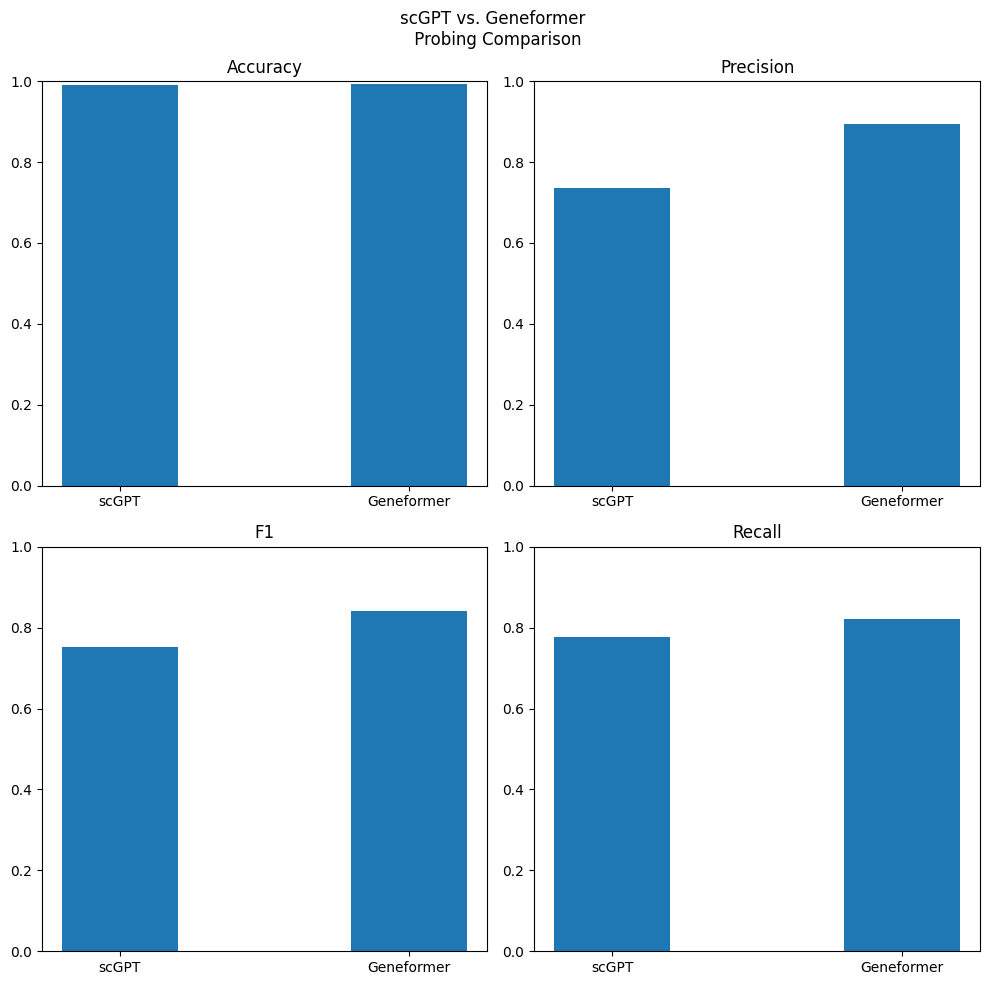

In [39]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

values_1 = [scgpt_results["accuracy"], geneformer_results["accuracy"]]
x = ["scGPT", "Geneformer"]
axs[0, 0].bar(x, values_1, width=0.4)
axs[0, 0].set_title("Accuracy")
axs[0, 0].set_ylim([0, 1])

values_2 = [scgpt_results["precision"], geneformer_results["precision"]]
axs[0, 1].bar(x, values_2, width=0.4)
axs[0, 1].set_title("Precision")
axs[0, 1].set_ylim([0, 1])

values_3 = [scgpt_results["f1"], geneformer_results["f1"]]
axs[1, 0].bar(x, values_3, width=0.4)
axs[1, 0].set_title("F1")
axs[1, 0].set_ylim([0, 1])

values_4 = [scgpt_results["recall"], geneformer_results["recall"]]
axs[1, 1].bar(x, values_4, width=0.4)
axs[1, 1].set_title("Recall")
axs[1, 1].set_ylim([0, 1])

fig.suptitle("scGPT vs. Geneformer \n Probing Comparison")
fig.tight_layout()
plt.show()



## scGPT
- Accuracy: 99.2%
- Precision: 90.8%
- Recall: 79.1%
- Macro F1: 80.7%

## Geneformer
- Accuracy: 98.9%
- Precision: 71.6%
- Recall: 73.6%
- Macro F1: 77.3%

 (c) Helical 2024 - Developed by the Helical Team